# Seattle Airbnb Open Data
### By Mehran Moazeni

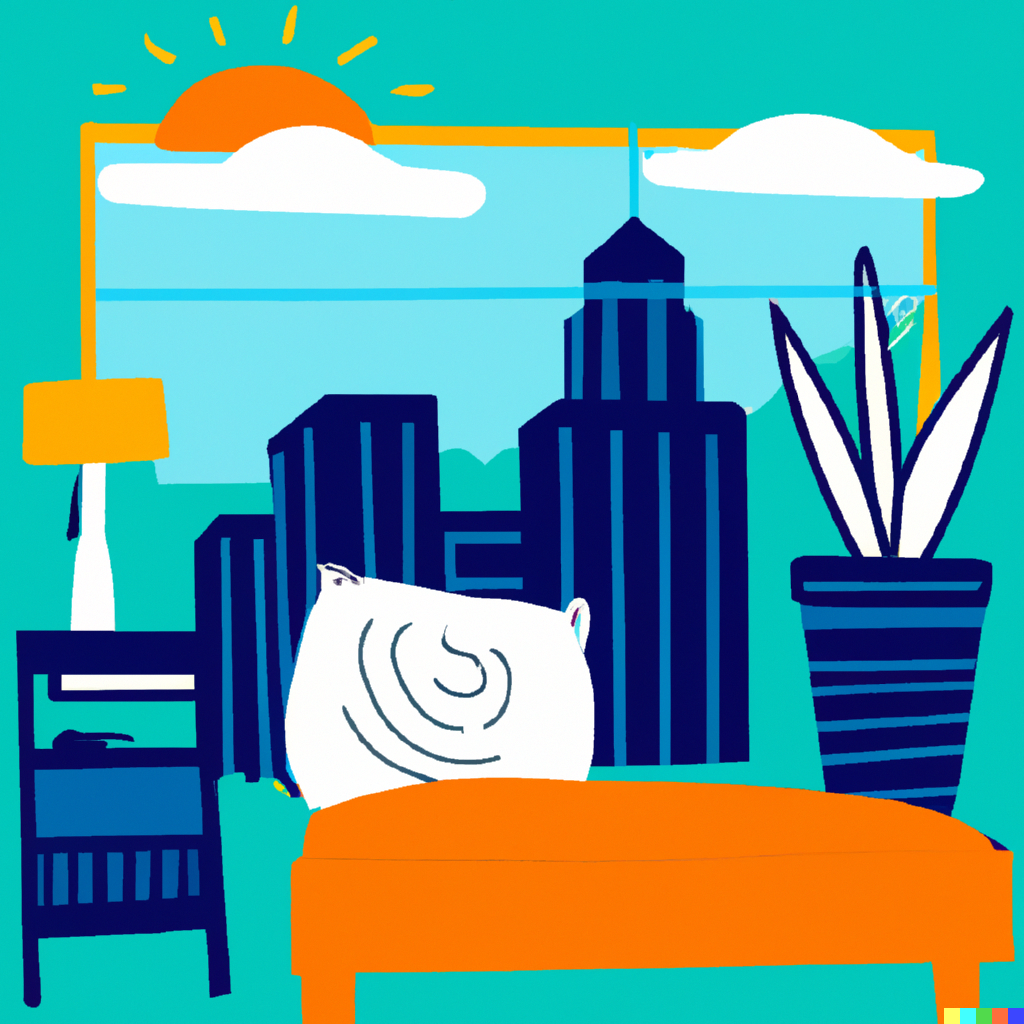

## Table of content

- Introduction
- Exploratory Data Analysis
- Conclusion

Introduction

For this project I decided to analyse the Wine Rating dataset found on Kaggle: https://www.kaggle.com/datasets/airbnb/seattle using the CRISP-DM Process of:

- Business Understanding
- Data Understanding
- Prepare Data
- Data Modeling
- Evaluate the Results
- Deploy

### Business understanding

 am a data scientist and I am excited to gain some insight into the Seatl Airbnb dataset. As a traveler, sometimes I am struck by the anxiety of how to choose the best Airbnb for me. It depends on the situation, is this Airbnb just for a quiet night in or is it for a special occasion? Maybe I'm trying to make a good impression with the Airbnb I book, or maybe I'm in an uncomfortable travel situation with the family!

To help travelers like me find the best Airbnb for their needs and budget, the following questions were posed:

- Where chractristics does a successful host have in Seatle Airbnbs?
- Is price related to Airbnb quality in Seatle?
- Are certain types of property that makes a host successful?
- What are the best Airbnbs in each price range?

### Exploratory Data Analysis
#### Prepare Data

First things first, let's import the required packages.

In [2]:
import pandas as pd
import glob
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import warnings

from collections import Counter
from scipy.stats.stats import pearsonr
from string import ascii_letters

# Plotly packages for visualization
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
from plotly import tools
init_notebook_mode(connected=True)

# Set display options
pd.set_option('display.max_columns', 500)
warnings.filterwarnings('ignore')
%matplotlib inline

# Define data correction functions
def clean_currency(x):
    if type(x) == str:
        x = x.replace('$', '').replace(',', '')
        x = float(x)
    return x

def clean_percentage(x):
    if type(x) == str:
        x = x.replace('%', '')
        x = float(x) / 100.0
    return x

def to_int(x):
    if x == 'f':
        x = x.replace('f', '0')
    elif x == 't':
        x = x.replace('t', '1')
    else:
        x = '0'
    return int(x)

def time_to_number(x):
    if x == 'within an hour':
        x = '1'
    elif x == 'within a few hours':
        x = '4'
    elif x == 'within a day':
        x = '24'
    elif x == 'a few days or more':
        x = '48'
    else:
        x = '96'
    return x

def number_to_time(x):
    if x == 1:
        x = 'within an hour'
    elif x == 4:
        x = 'within a few hours'
    elif x == 24:
        x = 'within a day'
    elif x == 48:
        x = 'a few days or more'
    elif x == 96:
        x = 'Not Response'
    return x

def create_amenities_list(x):
    val = x.replace('{', '').replace('}', '').replace('"', '').replace(' ', '_').replace(',', ' ')
    val = val.split()
    return val

def range_score(x):
    value = ''
    if x >= 0 and x < 10:
        value = '0-10'
    elif x >= 10 and x < 20:
        value = '10-20'
    elif x >= 20 and x < 30:
        value = '20-30'
    elif x >= 30.0 and x < 40.0:
        value = '30-40'
    elif x >= 40 and x < 50:
        value = '40-50'
    elif x >= 50 and x < 60:
        value = '50-60'
    elif x >= 60 and x < 70:
        value = '60-70'        
    elif x >= 70 and x < 80:
        value = '70-80'
    elif x >= 80 and x < 90:
        value = '80-90'
    elif x >= 90 and x < 100:
        value = '90-100'
    elif x >= 100:
        value = '100+'
    return value

# Define visualization functions
def create_xaxis(title):
    xaxis = dict(
        title=title,
        titlefont=dict(
            color='#AAAAAA'
        ),
        showgrid=False,
        color='#AAAAAA',
    )
    return xaxis

def yaxis_layout(title):
    """
    Creates the Y Axis layout and title
    """
    return dict(
        title=title,
        titlefont=dict(color='#AAAAAA'),
        showgrid=False,
        color='#AAAAAA',
    )


def layout(chart_title, x_title, y_title, l_margin, height, annotations=None):  
    """
    Creates whole layout, with both axis, annotations, size and margin
    """
    return go.Layout(
        title=chart_title, 
        height=height, 
        width=800,
        showlegend=False,
        xaxis=xaxis_layout(x_title), 
        yaxis=yaxis_layout(y_title),
        annotations=annotations,
        margin=dict(l=l_margin),
    )


def bars(data, color, orientation):
    """
    Generates the bars for plotting, with their color and orientation
    """
    bars = []
    for label, label_df in data.groupby(color):
        if orientation == 'h':
            label_df = label_df.sort_values(by='x', ascending=True)
        if label == 'a':
            label = 'lightgray'
        bars.append(go.Bar(
            x=label_df.x,
            y=label_df.y,
            name=label,
            marker={'color': label},
            orientation=orientation
        ))
    return bars


def annotations(annot):
    """
    Generates annotations to insert in the chart
    """
    if annot is None:
        return []
    
    annotations = []
    # Adding labels
    for d in annot:
        annotations.append(dict(
            xref='paper', 
            x=d['x'], 
            y=d['y'],
            xanchor='left', 
            yanchor='bottom',
            text=d['text'],
            font=dict(size=13, color=d['color']),
            showarrow=False
        ))
    return annotations


def generate_barplot(text, annot_dict, orientation='v', l_margin=120, height=400):
    """
    Generate the barplot with all data, using previous helper functions
    """
    layout_ = layout(text[0], text[1], text[2], l_margin, height, annotations(annot_dict))
    fig = go.Figure(data=bars(barplot, 'color', orientation=orientation), layout=layout_)
    return iplot(fig)



Now I am going to import data folder into Python.

In [3]:
csvs = glob.glob('/Users/Moaze002/Documents/Udacity-DataScience Nanodegree/data/external/archive/*.csv')
base= pd.read_csv(csvs[1])
listings_df= base.copy()
listings_df.head(2)


,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,market,smart_location,country_code,country,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,NaN,NaN,NaN,NaN,https://a1.muscache.com/ac/pictures/67560560/c...,NaN,956883,https://www.airbnb.com/users/show/956883,Maija,2011-08-11,"Seattle, Washington, United States","I am an artist, interior designer, and run a s...",within a few hours,96%,100%,f,https://a0.muscache.com/ac/users/956883/profil...,https://a0.muscache.com/ac/users/956883/profil...,Queen Anne,3.0,3.0,"['email', 'phone', 'reviews', 'kba']",t,t,"Gilman Dr W, Seattle, WA 98119, United States",Queen Anne,West Queen Anne,Queen Anne,Seattle,WA,98119,Seattle,"Seattle, WA",US,United States,47.636289,-122.371025,t,Apartment,Entire home/apt,4,1.0,1.0,1.0,Real Bed,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",NaN,$85.00,NaN,NaN,NaN,NaN,2,$5.00,1,365,4 weeks ago,t,14,41,71,346,2016-01-04,207,2011-11-01,2016-01-02,95.0,10.0,10.0,10.0,10.0,9.0,10.0,f,NaN,WASHINGTON,f,moderate,f,f,2,4.07
1,953595,https://www.airbnb.com/rooms/953595,20160104002432,2016-01-04,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,none,"Queen Anne is a wonderful, truly functional vi...",What's up with the free pillows? Our home was...,"Convenient bus stops are just down the block, ...",https://a0.muscache.com/ac/pictures/14409893/f...,https://a0.muscache.com/im/pictures/14409893/f...,https://a0.muscache.com/ac/pictures/14409893/f...,https://a0.muscache.com/ac/pictures/14409893/f...,5177328,https://www.airbnb.com/users/show/5177328,Andrea,2013-02-21,"Seattle, Washington, United States",Living east coast/left coast/overseas. Time i...,within an hour,98%,100%,t,https://a0.muscache.com/ac/users/5177328/profi...,https://a0.muscache.com/ac/users/5177328/profi...,Queen Anne,6.0,6.0,"['email', 'phone', 'facebook', 'linkedin', 're...",t,t,"7th Avenue West, Seattle, WA 98119, United States",Queen Anne,West Queen Anne,Queen Anne,Seattle,WA,98119,Seattle,"Seattle, WA",US,United States,47.639123,-122.365666,t,Apartment,Entire home/apt,4,1.0,1.0,1.0,Real Bed,"{TV,Internet,""Wireless Internet"",Kitchen,""Free...",NaN,$150.00,"$1,000.00","$3,000.00",$100.00,$40.00,1,$0.00,2,90,today,t,13,13,16,291,2016-01-04,43,2013-08-19,2015-12-29,96.0,10.0,10.0,10.0,10.0,10.0,10.0,f,NaN,WASHINGTON,f,strict,t,t,6,1.48


In [36]:
# number of rows
listings_df.shape[0]

3818

In [37]:
# columns:
listings_df.shape[1]

92

In [4]:
listings_df.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'summary',
       'space', 'description', 'experiences_offered', 'neighborhood_overview',
       'notes', 'transit', 'thumbnail_url', 'medium_url', 'picture_url',
       'xl_picture_url', 'host_id', 'host_url', 'host_name', 'host_since',
       'host_location', 'host_about', 'host_response_time',
       'host_response_rate', 'host_acceptance_rate', 'host_is_superhost',
       'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood',
       'host_listings_count', 'host_total_listings_count',
       'host_verifications', 'host_has_profile_pic', 'host_identity_verified',
       'street', 'neighbourhood', 'neighbourhood_cleansed',
       'neighbourhood_group_cleansed', 'city', 'state', 'zipcode', 'market',
       'smart_location', 'country_code', 'country', 'latitude', 'longitude',
       'is_location_exact', 'property_type', 'room_type', 'accommodates',
       'bathrooms', 'bedrooms', 'beds', 'bed_type', 'amenities', '

### Assessing the imported data

From the codes above, we can conferm that we have 3818 rows, and 92 features. The columns that are import for the next parts are as follow:

- <b>host_response_rate</b> The rate of reposnes from the host to the request of guests. 
- <b>host_acceptance_rate</b> The rate of accpeting a request from host.
- <b>number_of_reviews</b> 
- <b>review_scores_checkin</b> Review related to checkin for a host
- <b>review_scores_value</b> The score related to past reviews for a spcecific host.

We have to apply a sort of threshold, to see which listing is performing better than others (also same for the bad perfromer). 

In [5]:
# info about datatypes and nulls
listings_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3818 entries, 0 to 3817
Data columns (total 92 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   id                                3818 non-null   int64  
 1   listing_url                       3818 non-null   object 
 2   scrape_id                         3818 non-null   int64  
 3   last_scraped                      3818 non-null   object 
 4   name                              3818 non-null   object 
 5   summary                           3641 non-null   object 
 6   space                             3249 non-null   object 
 7   description                       3818 non-null   object 
 8   experiences_offered               3818 non-null   object 
 9   neighborhood_overview             2786 non-null   object 
 10  notes                             2212 non-null   object 
 11  transit                           2884 non-null   object 
 12  thumbn

Seems `square_feet` and `liscens` have a lot of missing values and hence we have to drop them. Since I want to use  `host_response_rate` column, I only will correct missing valeus in this column with mean of all hosts.

In [19]:
listings_df['host_response_rate']= listings_df['host_response_rate'].apply(clean_percentage)
listings_df['host_response_rate'] = listings_df['host_response_rate'].fillna(listings_df['host_response_rate'].dropna().astype(float).mean())



In [7]:
listings_df.describe()

,id,scrape_id,host_id,host_listings_count,host_total_listings_count,latitude,longitude,accommodates,bathrooms,bedrooms,beds,square_feet,guests_included,minimum_nights,maximum_nights,availability_30,availability_60,availability_90,availability_365,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,calculated_host_listings_count,reviews_per_month
count,3.818000e+03,3.818000e+03,3.818000e+03,3816.000000,3816.000000,3818.000000,3818.000000,3818.000000,3802.000000,3812.000000,3817.000000,97.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3171.000000,3160.000000,3165.000000,3160.000000,3167.000000,3163.000000,3162.000000,0.0,3818.000000,3191.000000
mean,5.550111e+06,2.016010e+13,1.578556e+07,7.157757,7.157757,47.628961,-122.333103,3.349398,1.259469,1.307712,1.735394,854.618557,1.672603,2.369303,780.447617,16.786276,36.814825,58.082504,244.772656,22.223415,94.539262,9.636392,9.556398,9.786709,9.809599,9.608916,9.452245,NaN,2.946307,2.078919
std,2.962660e+06,0.000000e+00,1.458382e+07,28.628149,28.628149,0.043052,0.031745,1.977599,0.590369,0.883395,1.139480,671.404893,1.311040,16.305902,1683.589007,12.173637,23.337541,34.063845,126.772526,37.730892,6.606083,0.698031,0.797274,0.595499,0.568211,0.629053,0.750259,NaN,5.893029,1.822348
min,3.335000e+03,2.016010e+13,4.193000e+03,1.000000,1.000000,47.505088,-122.417219,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,20.000000,2.000000,3.000000,2.000000,2.000000,4.000000,2.000000,NaN,1.000000,0.020000
25%,3.258256e+06,2.016010e+13,3.275204e+06,1.000000,1.000000,47.609418,-122.354320,2.000000,1.000000,1.000000,1.000000,420.000000,1.000000,1.000000,60.000000,2.000000,13.000000,28.000000,124.000000,2.000000,93.000000,9.000000,9.000000,10.000000,10.000000,9.000000,9.000000,NaN,1.000000,0.695000
50%,6.118244e+06,2.016010e+13,1.055814e+07,1.000000,1.000000,47.623601,-122.328874,3.000000,1.000000,1.000000,1.000000,750.000000,1.000000,2.000000,1125.000000,20.000000,46.000000,73.000000,308.000000,9.000000,96.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,NaN,1.000000,1.540000
75%,8.035127e+06,2.016010e+13,2.590309e+07,3.000000,3.000000,47.662694,-122.310800,4.000000,1.000000,2.000000,2.000000,1200.000000,2.000000,2.000000,1125.000000,30.000000,59.000000,89.000000,360.000000,26.000000,99.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,NaN,2.000000,3.000000
max,1.034016e+07,2.016010e+13,5.320861e+07,502.000000,502.000000,47.733358,-122.240607,16.000000,8.000000,7.000000,15.000000,3000.000000,15.000000,1000.000000,100000.000000,30.000000,60.000000,90.000000,365.000000,474.000000,100.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,NaN,37.000000,12.150000


The Seattle Airbnb market has a total of ‍‍`3,818` listings, with an average price of `$137` per night. The majority of these listings are for entire homes or apartments (`60.6%`), followed by private rooms (`34.5%`) and shared rooms (`4‍.9%`).

The average rating for Seattle Airbnb listings ‍‍‍‍‍is ‍`4.64` out of `5` stars, indicating a generally positive experience for guests. The most common amenities offered by hosts include wireless internet, heating, and kitchens.‍

The neighborhoods with the highest number of Airbnb listings in Seattle are Capitol Hill, Downtown, and Central Area, which together make up nearly half of all listings in the city. These neighborhoods also tend to have higher average prices compared to other areas.

Overall, the Seattle Airbnb market offers a variety of options for travelers seeking affordable accommodations in a city known for its beautiful scenery, vibrant culture, and thriving tech industry.

In [21]:
# check out the number of property
listings_df.property_type.value_counts()

House              1733
Apartment          1708
Townhouse           118
Condominium          91
Loft                 40
Bed & Breakfast      37
Other                22
Cabin                21
Camper/RV            13
Bungalow             13
Boat                  8
Tent                  5
Treehouse             3
Dorm                  2
Chalet                2
Yurt                  1
Name: property_type, dtype: int64

Majority of accomodations are House and the Apartments

 let's look at the distribution of the prices:

In [35]:
listings_df['price'].min()

20.0

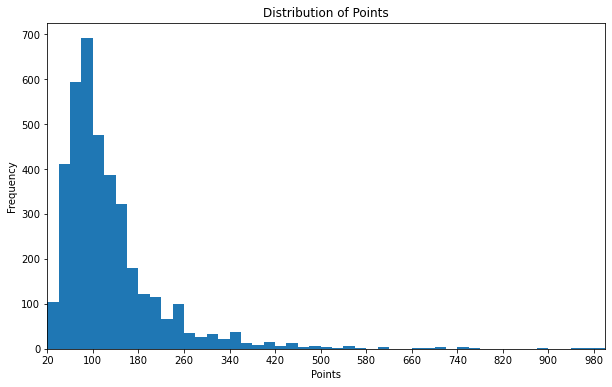

In [52]:
# Create a histogram to display the distribution of prices
listings_df['price'] = listings_df['price'].apply(lambda p: float(p[1:].replace(',', '')) if isinstance(p, str) else p)

fig, ax = plt.subplots(figsize=(10, 6))
bins = np.arange(20, listings_df['price'].max() + 1, 20)
ax.hist(x='price', data=listings_df, bins=bins)

# Set the x-axis limits and labels
ax.set_xlim(20, 1000)
ax.set_xlabel('Points')
ax.set_ylabel('Frequency')
ax.set_title('Distribution of Points')
plt.xticks(np.arange(20, 1000, 80));



Most of the prices are around 100$ per night. 

Now let's look at which neighbourhoods are having the highest prices

In [53]:
# group numerical variables by country 
df_neighbourhood = listings_df.groupby('neighbourhood').agg('mean')

In [56]:
# create df with 10 countries with most average points
df_neighbourhood_sorted = df_neighbourhood[['price']].sort_values(by='price', ascending=False)[:10]
df_neighbourhood_sorted


,price
neighbourhood,
Fairmount Park,370.000000
Industrial District,245.000000
Portage Bay,241.428571
Westlake,197.000000
Alki,196.652174
Montlake,195.947368
Magnolia,176.000000
Pike Place Market,175.512821
Windermere,174.700000


`Fairmount Park` has the highest average price for a one night stay

### Data Modeling

I will make a new score to understand wich host perform successful on the pltaform and which host performs unsuccessful. I will call them the G and B perfomers. 

In [3]:
# make a score: combination of reviews per month & score rating:
def calculate_new_score_reviews(row):
    reviews_per_month = row['reviews_per_month']
    review_scores_rating = row['review_scores_rating']
    if pd.isna(reviews_per_month) or pd.isna(review_scores_rating):
        return 0
    return reviews_per_month * review_scores_rating / 10

listings_df['new_score_reviews'] = listings_df.apply(calculate_new_score_reviews, axis=1)
listings_df['new_score_reviews']


0       38.665
1       14.208
2       11.155
3        0.000
4        8.188
         ...  
3813     2.400
3814    20.000
3815     0.000
3816     0.000
3817     0.000
Name: new_score_reviews, Length: 3818, dtype: float64

In [4]:
top = listings_df['new_score_reviews'].quantile(0.9)
bottom = listings_df['new_score_reviews'].quantile(0.2)

listings_df['top'] = listings_df.new_score_reviews >= top
listings_df['bottom'] = listings_df.new_score_reviews <= bottom

print('Threshold for best performer listings:', top)
print('Threshold for bad performer listings:', bottom)


Threshold for best performer listings: 41.27720000000001
Threshold for bad performer listings: 1.6764000000000006


No we want to plot this threshold for different range of scores to see how the scores are distributed.

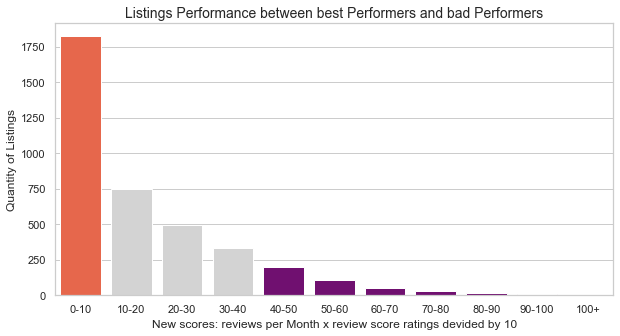

In [39]:
### Create a table for the visualization essentials ###
### Generate score bins, creating new tables for the class colors, and count distributions of each bins. ###
# a columns of bins.
listings_df['score_ranges'] = listings_df['new_score_reviews'].apply(range_score)

# table coloring purpose.
top = listings_df.groupby('score_ranges', as_index = False)['top'].max().rename(columns={'score_ranges':'Score'})
bot = listings_df.groupby('score_ranges', as_index = False)['bottom'].max().rename(columns={'score_ranges':'Score'})

# count distributions of score bins.
barplot = listings_df[['id','new_score_reviews']]
barplot['Qty'] = barplot['new_score_reviews'].apply(range_score)
barplot = barplot.Qty.value_counts(sort=True).to_frame().reset_index()
barplot = barplot.rename(columns={'index': 'Score'})

# merging color flag.
barplot = barplot.merge(top, on = 'Score')
barplot = barplot.merge(bot)
# creating color for the vis.
barplot['color'] = barplot.top.apply(lambda x: 'purple' if x else 'lightgray')
# manually change the color of the first index become crimson, to indicate the class of low performer listings.
barplot.iloc[0,4] = '#FF5733'

# change Score column and Qty column into x and y for the vis purpose.
barplot = barplot.rename(columns={'Score':'x','Qty':'y'})

# Some of the annotations for the vis.
title_text = ['Listings Performance between best Performers and bad Performers', 'New scores: reviews per Month x review score ratings devided by 10', 'Quantity of Listings']


# Generate the bar plot
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 5))
sns.barplot(x='x', y='y', data=barplot, palette=barplot.color)
plt.title(title_text[0], fontsize=14)
plt.xlabel(title_text[1], fontsize=12)
plt.ylabel(title_text[2], fontsize=12)


plt.show()


In the bar chart, red bar represents bas performer listings with scores falling below the 20th percentile, while the medium aquamarine bar represents high performer listings with scores above the 90th percentile.

Now to look for relevant features in the dataset, I will use pair plot, which allows us to visualize the pairwise relationships between each features. Fo rthis purpose, I have selected the relevant feastures first and then use the `sns.pairplot`. The diagonal shows histograms of each feature's distribution, while the off-diagonal plots show scatterplots with linear regression lines and kernel density estimates. We can use this plot to look for patterns and correlations between the review score features.

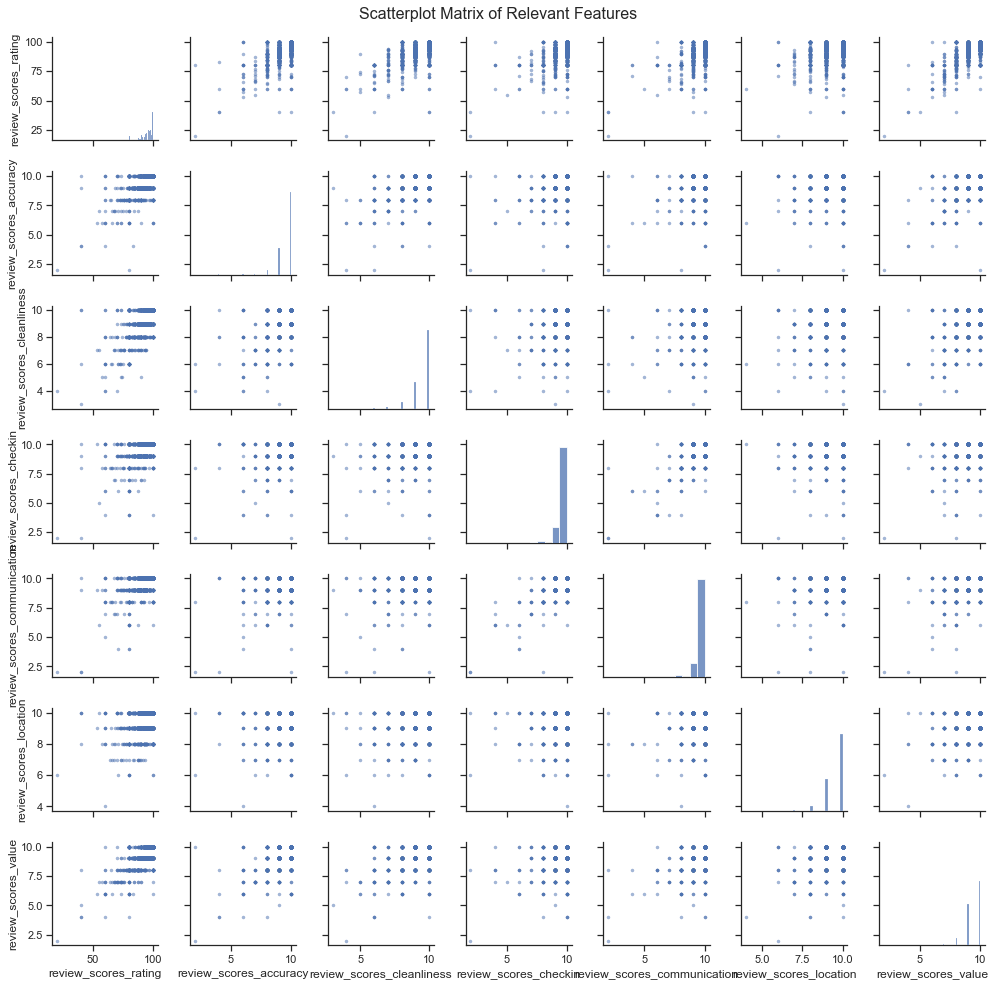

<Figure size 432x288 with 0 Axes>

In [7]:
# Create a scatterplot matrix of relevant features
relevant_df = listings_df[['review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value']]
sns.set(style="ticks")
sns.pairplot(relevant_df, diag_kind='hist', height=2, plot_kws=dict(s=10, edgecolor="b", alpha=0.5))
plt.subplots_adjust(wspace=0.3, hspace=0.3,top=0.95)
plt.suptitle('Scatterplot Matrix of Relevant Features', fontsize=16)
plt.show()
plt.tight_layout()


We can obtain some information from the above figure, but still we can direclty look into the correlations. So maybe a cluster corraltion plot could save us some time!

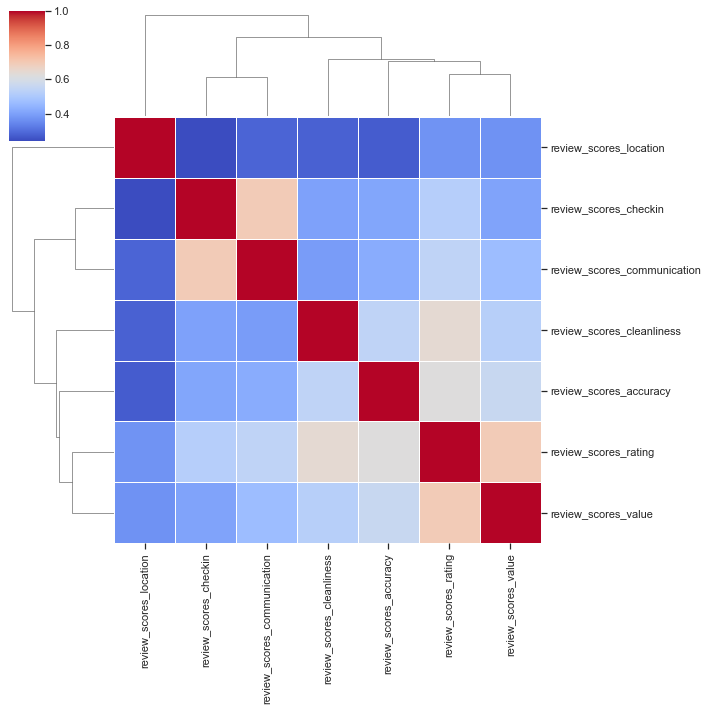

In [62]:
# Compute the correlation matrix
corr = relevant_df.corr()

# Create a clustered heatmap
sns.clustermap(corr, cmap='coolwarm', linewidths=.5, figsize=(10, 10));

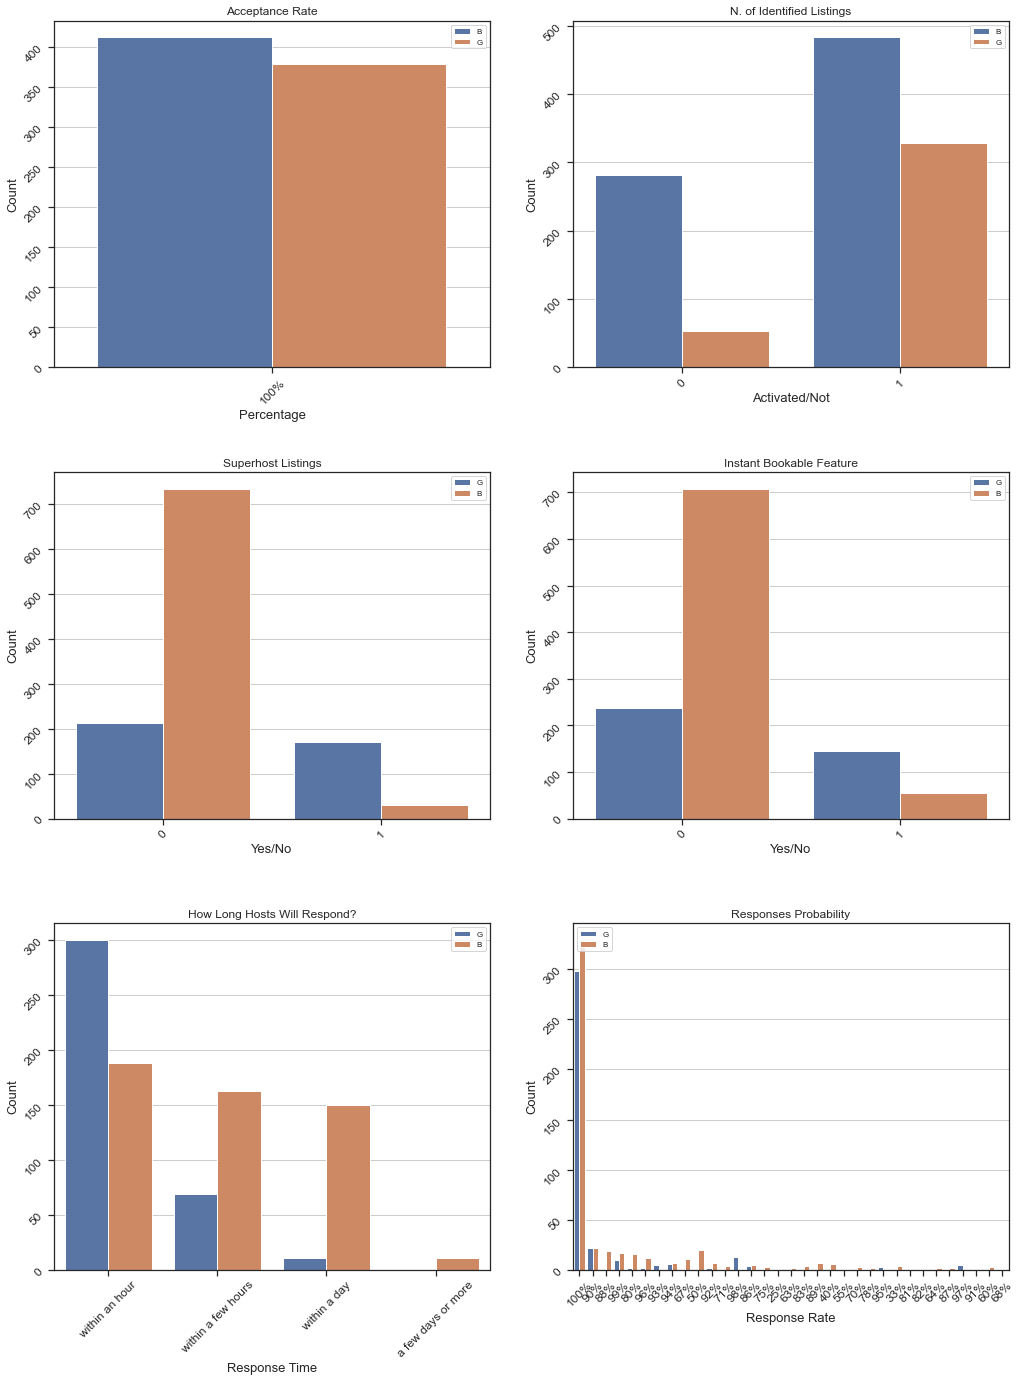

In [8]:
# Split listings into top and low performers
top_listings = listings_df[listings_df['new_score_reviews'] >= np.percentile(listings_df['new_score_reviews'],90)]
low_listings = listings_df[listings_df['new_score_reviews'] <= np.percentile(listings_df['new_score_reviews'],20)]

# Create dataframes for each host attribute
hostAR_top = top_listings[['host_acceptance_rate']].assign(status='G')
hostAR_low = low_listings[['host_acceptance_rate']].assign(status='B')
hostAR = pd.concat([hostAR_top, hostAR_low]).sample(frac=1)



verified_top = top_listings[['host_identity_verified']].assign(status='G')
verified_low = low_listings[['host_identity_verified']].assign(status='B')
verified = pd.concat([verified_top, verified_low]).sample(frac=1)
verified['host_identity_verified'] = verified['host_identity_verified'].apply(to_int)


superhost_top = top_listings[['host_is_superhost']].assign(status='G')
superhost_low = low_listings[['host_is_superhost']].assign(status='B')
superhost = pd.concat([superhost_top, superhost_low]).sample(frac=1)
superhost['host_is_superhost'] = superhost['host_is_superhost'].apply(to_int)

bookable_top = top_listings[['instant_bookable']].assign(status='G')
bookable_low = low_listings[['instant_bookable']].assign(status='B')
bookable = pd.concat([bookable_top, bookable_low]).sample(frac=1)
bookable['instant_bookable'] = bookable['instant_bookable'].apply(to_int)


response_top = top_listings[['host_response_time']].assign(status='G')
response_low = low_listings[['host_response_time']].assign(status='B')
response = pd.concat([response_top, response_low]).sample(frac=1)
response['host_response_time'] = response['host_response_time'].apply(number_to_time)

response_rate_top = top_listings[['host_response_rate']].assign(status='G')
response_rate_low = low_listings[['host_response_rate']].assign(status='B')
response_rate = pd.concat([response_rate_top, response_rate_low]).sample(frac=1)

# Create figure and axes
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(15, 20))

# Create data and plot each attribute
data = [hostAR, verified, superhost, bookable, response, response_rate]
x_labels = ['Percentage', 'Activated/Not', 'Yes/No', 'Yes/No', 'Response Time', 'Response Rate']
y_labels = ['Count']
titles = ['Acceptance Rate', 'N. of Identified Listings', 'Superhost Listings', 'Instant Bookable Feature', 
          'How Long Hosts Will Respond?', 'Responses Probability']

for idx, ax in enumerate(axs.ravel()):
    sns.countplot(x=list(data[idx].columns)[0], hue='status', data=data[idx], ax=ax, orient='h')
    ax.set_title(titles[idx], fontsize=12)
    ax.set_xlabel(x_labels[idx], fontsize=13)
    ax.set_ylabel(y_labels[0], fontsize=13)
    ax.tick_params(labelsize=12, rotation=45)
    ax.legend(fontsize=8, title=None)
    ax.yaxis.grid(True)


# Remove unused axes
for i in range(len(data), len(axs.ravel())):
    fig.delaxes(axs.ravel()[i])
    
# Tighten the layout
fig.tight_layout(pad=3.0)


Now we can see the pricing of good performers and bad performers:

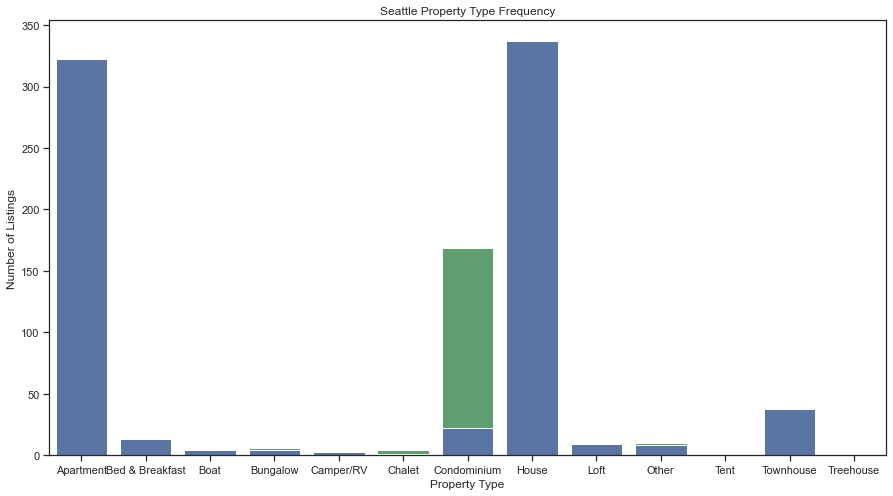

In [25]:
top_listings = listings_df[listings_df['new_score_reviews'] >= np.percentile(listings_df['new_score_reviews'],90)].assign(status='G')
low_listings = listings_df[listings_df['new_score_reviews'] <= np.percentile(listings_df['new_score_reviews'],20)].assign(status='B')


required_df =  pd.concat([top_listings, low_listings])



required_df1 = required_df.groupby(['property_type', 'status']).id.count().reset_index()
required_df1= required_df1.reset_index()

# objects = propertytype_DF['property_type']
# y_pos = propertytype_DF['Number_Of_Listings']

fig, ax = plt.subplots(figsize=(15, 8))
sns.barplot(data=required_df1[required_df1['status'] == 'G'], x='property_type', y='id', color='g', ax=ax)
sns.barplot(data=required_df1[required_df1['status'] == 'B'], x='property_type', y='id', color='b', ax=ax)
ax.set(title='Seattle Property Type Frequency', xlabel='Property Type', ylabel='Number of Listings')
plt.show()

Now, I wan to see how the performance related to the prices on the website. 

In [30]:
required_df['price'] = required_df['price'].apply(lambda p: float(p[1:].replace(',', '')) if isinstance(p, str) else p)

price_GB = required_df.groupby(['property_type','room_type', 'status']).price.mean()
price_GB = price_GB.reset_index()
price_GB=price_GB.sort_values('price',ascending=[0])
price_GB.head()

,property_type,room_type,status,price
17,Camper/RV,Entire home/apt,B,320.000000
42,Townhouse,Entire home/apt,B,218.052632
26,House,Entire home/apt,B,214.050279
33,Loft,Private room,B,175.000000
32,Loft,Entire home/apt,G,168.166667


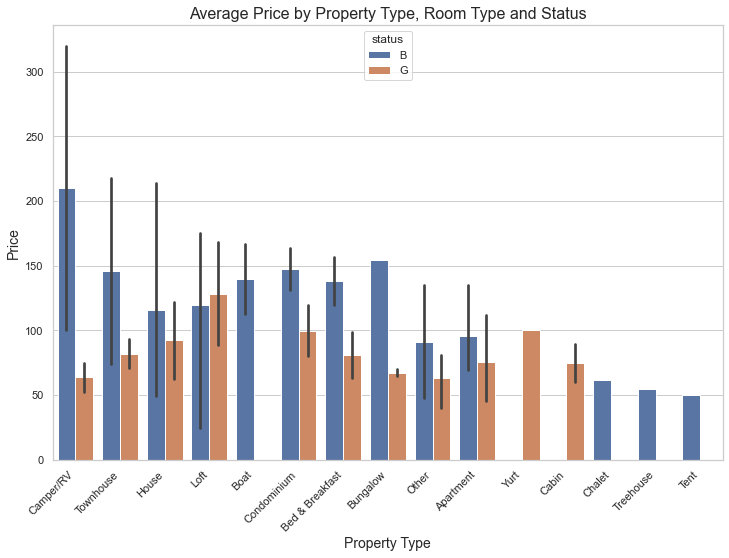

<function matplotlib.pyplot.tight_layout(*, pad=1.08, h_pad=None, w_pad=None, rect=None)>

In [36]:
sns.set(style="whitegrid")

plt.figure(figsize=(12,8))
ax = sns.barplot(x="property_type", y="price", hue="status", data=price_GB)

plt.title("Average Price by Property Type, Room Type and Status", fontsize=16)
plt.xlabel("Property Type", fontsize=14)
plt.xticks(rotation=45, ha='right')

plt.ylabel("Price", fontsize=14)

plt.show()
plt.tight_layout